In [ ]:
import torch
import torch.nn as nn
import csv
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [2]:
# 从CSV文件加载数据
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # 跳过文件头部
        for line in reader:
            sentence, label = line
            # 将标签转为整型，这里我们把'positive'转为1，把'negative'转为0
            label = 1 if label == 'positive' else 0
            data.append((sentence, label))  
    return data

In [3]:
# 数据集类
class IMDbDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.tokenizer = tokenizer
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, label = self.data[idx]
        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask, torch.tensor(label)  # 标签转为Tensor类型

In [4]:
# 定义自定义模型
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.neck = nn.Linear(hidden_dim, 256)
        self.tail = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        _, (h_n, _) = self.lstm(embedded)
        features = self.neck(h_n[-1])
        features = self.dropout(features)
        logits = self.tail(features)
        return logits

In [5]:
# 定义CLEAN算法
def clean_algorithm(predictions, labels, threshold):
    clean_indices = []
    for i in range(len(predictions)):
        # 检查 predictions[i] 和 labels[i] 是数字还是列表/数组
        if np.isscalar(predictions[i]) and np.isscalar(labels[i]):
            if predictions[i] - labels[i] >= threshold:
                clean_indices.append(i)
        else:
            if max(predictions[i]) - predictions[i][labels[i]] >= threshold:
                clean_indices.append(i)
    return clean_indices

In [7]:
# 加载数据集并进行分割
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
data = load_data('IMDB-NY.csv')
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
# 获取词汇表大小
vocab_size = len(tokenizer)

In [9]:
# 创建训练集和验证集
train_dataset = IMDbDataset(train_data, tokenizer)
val_dataset = IMDbDataset(val_data, tokenizer)

In [10]:
# 定义超参数
batch_size = 32
num_classes = 2
embedding_dim = 128
hidden_dim = 256
num_epochs = 50
threshold = 0.5

In [11]:
# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [12]:
# 构建模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(embedding_dim, hidden_dim, num_classes).to(device)

In [13]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [14]:
# 训练模型
best_val_loss = float('inf')
no_improve_epoch = 0
max_no_improve_epoch = 10

In [15]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 计算准确度
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(train_dataloader)
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

    # 验证步骤
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for val_batch in val_dataloader:
            val_input_ids, val_attention_mask, val_labels = val_batch
            val_input_ids = val_input_ids.to(device)
            val_attention_mask = val_attention_mask.to(device)
            val_labels = val_labels.to(device)  # 现在val_labels也是一个Tensor，可以被移动到设备

            val_logits = model(val_input_ids, val_attention_mask)
            val_loss = criterion(val_logits, val_labels)

            total_val_loss += val_loss.item()

            # 计算验证集的准确度
            val_predictions = torch.argmax(val_logits, dim=1)
            total_val_correct += (val_predictions == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
            all_val_predictions.extend(val_predictions.cpu().numpy())
            all_val_labels.extend(val_labels.cpu().numpy())

    average_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = total_val_correct / total_val_samples
    print(f'Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # 使用CLEAN算法检测噪声
    clean_indices = clean_algorithm(all_val_predictions, all_val_labels, threshold)
    clean_val_labels = np.array(all_val_labels)[clean_indices]
    clean_val_predictions = np.array(all_val_predictions)[clean_indices]

Epoch 1/50, Loss: 0.6934, Accuracy: 0.5022
Val Loss: 0.6929, Val Accuracy: 0.5126
Epoch 2/50, Loss: 0.6928, Accuracy: 0.5133
Val Loss: 0.6926, Val Accuracy: 0.5104
Epoch 3/50, Loss: 0.6922, Accuracy: 0.5183
Val Loss: 0.6922, Val Accuracy: 0.5123
Epoch 4/50, Loss: 0.6913, Accuracy: 0.5282
Val Loss: 0.6918, Val Accuracy: 0.5164
Epoch 5/50, Loss: 0.6897, Accuracy: 0.5354
Val Loss: 0.6914, Val Accuracy: 0.5221
Epoch 6/50, Loss: 0.6873, Accuracy: 0.5477
Val Loss: 0.6912, Val Accuracy: 0.5300
Epoch 7/50, Loss: 0.6789, Accuracy: 0.5681
Val Loss: 0.6754, Val Accuracy: 0.5808
Epoch 8/50, Loss: 0.6603, Accuracy: 0.6073
Val Loss: 0.6653, Val Accuracy: 0.6015
Epoch 9/50, Loss: 0.6490, Accuracy: 0.6266
Val Loss: 0.6610, Val Accuracy: 0.6110
Epoch 10/50, Loss: 0.6424, Accuracy: 0.6360
Val Loss: 0.6566, Val Accuracy: 0.6149
Epoch 11/50, Loss: 0.6347, Accuracy: 0.6467
Val Loss: 0.6512, Val Accuracy: 0.6253
Epoch 12/50, Loss: 0.6289, Accuracy: 0.6567
Val Loss: 0.6499, Val Accuracy: 0.6261
Epoch 13/50, 

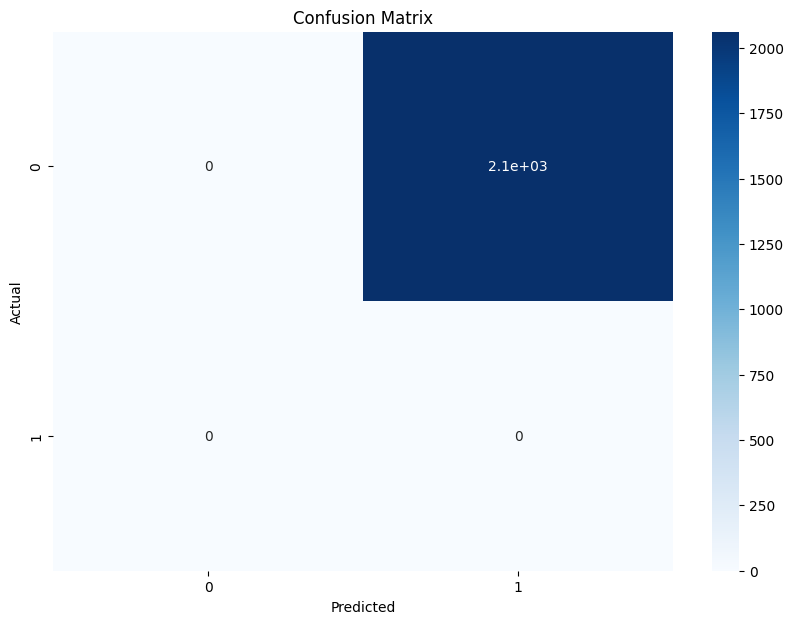

In [16]:
# 生成混淆矩阵
cm = confusion_matrix(clean_val_labels, clean_val_predictions)

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()